# **Librerías**



In [1]:
#COVID 19 Peru
#COVID 19 Arequipa
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import time
import torch
import statistics

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from tqdm             import tqdm
from IPython.display  import display 

from torch import nn
from torch import optim
from torch.optim import lr_scheduler

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
#Valores para resultados reproducibles
torch.manual_seed(10)
torch.cuda.manual_seed(10)
np.random.seed(10)
torch.backends.cudnn.deterministic = True

# **Exploración y lectura de Datos**

In [4]:
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
torch.cuda.is_available()

True

Casos Positivos
https://www.datosabiertos.gob.pe/dataset/casos-positivos-por-covid-19-ministerio-de-salud-minsa

Fallecidos
https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

#/mydrive/Colab\ Notebooks/Firearm/Gun/0a1a98d301f0fdb80b4d2c661d7be95baf24a81c.JPEG

file_pos = "/mydrive/ProyectoIA/positivos_covid"
file_death = "/mydrive/ProyectoIA/fallecidos_covid"

Mounted at /content/gdrive
'08 01 17 | L10 | [Condensed] Dynamic Programming I.gslides'
 08-address-translation.gslides
 09-caches-tlbs.gslides
 10-pagereplace.gslides
 11-io.pptx
 12-filesystems.ppt
 13-FileSystems.pptx
 14-Virtualization.pptx
 15-fault-tolerance.gslides
 15-fault-tolerance.ppt
 2020_MATCOMP_CCOMP6_1_Sergio_AquiseEXFINALFORMATO.gdoc
'3. Disposiciones'
'5 Artículos.gdoc'
'A Few Good Men -  Cuestión de Honor.gdoc'
'Agenda 2020 I.gdoc'
'Agenda 2020-II.gdoc'
 AHYA
'Algoritmo de Viterbi_.gslides'
'A Novel Graph-Based Energy Management System (1).gdoc'
'A Novel Graph-Based Energy Management System.gdoc'
'Artículo Tópicos IA Covid.gdoc'
'Avance 1 Proyectos.gdoc'
'Avance curricular hasta ahora- GPA.gsheet'
 AVANCEII.pdf
'avance pat-des.odt'
 Avl_tree.cpp
 BASE-01.pptx.gslides
'Bases de Datos II (1).ppt'
'Bases de Datos II.gslides'
'Bases de Datos II.ppt'
'Bases de Datos II.ppt.gslides'
'BD2 Isolation examples.gdoc'
'BD2 LSA.gslides'
'Big Data Model Simulation on a Graph D

In [7]:
def LeerDatos(filename : str, header = True):
    if (header):
        date_cols = ['FECHA_RESULTADO']
        #dateparse = lambda x: pd.datetime.strptime(x, "%d/%m/%Y")
        dateparse = lambda x: pd.datetime.strptime(x, "%Y%m%d")
        data = pd.read_csv(filename + ".csv", sep =';', header = 0, encoding = "ISO-8859-1")
    else:
        data = pd.read_csv(filename+ ".csv", sep =',', header = None)
    #data = data.sort_values(data.columns[-1])
    #return np.array(data.iloc[:,:])
    #return data.to_numpy()
    return data

In [8]:
data_pos = LeerDatos(file_pos)
data_fa = LeerDatos(file_death)

In [9]:
data_pos

,ï»¿FECHA_CORTE,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
0,20201209,7320cabdc1aaca6c59014cae76a134e6,LIMA REGION,EN INVESTIGACIÃN,EN INVESTIGACIÃN,PCR,41.0,MASCULINO,20200527.0
1,20201209,e81602051997ace8340bb8c18fe24c65,LIMA,LIMA,BREÃA,PCR,41.0,MASCULINO,20200511.0
2,20201209,cecdbf10074dbc011ae05b3cbd320a6f,LIMA,LIMA,LIMA,PCR,51.0,MASCULINO,20200411.0
3,20201209,71ecb6bccb248b0bb2ac72ed51b5e979,LIMA,LIMA,SAN BORJA,PCR,26.0,FEMENINO,20200411.0
4,20201209,566af4276cbe9359abe93f9aa86396c3,CALLAO,CALLAO,BELLAVISTA,PCR,47.0,MASCULINO,20200415.0
...,...,...,...,...,...,...,...,...,...
979106,20201209,83e463e6ba1475b3adf47a14aec4c1a9,CALLAO,CALLAO,CALLAO,PR,44.0,MASCULINO,20201120.0
979107,20201209,24b1a51a3f56a21a612fa046018f4081,CUSCO,URUBAMBA,MACHUPICCHU,PR,20.0,FEMENINO,20201127.0
979108,20201209,ab441734c7186c686d3960876cd955c8,JUNIN,HUANCAYO,CHILCA,PR,44.0,MASCULINO,20201129.0
979109,20201209,7c2b520da2366ba0de03d6d63dc4b823,LIMA REGION,BARRANCA,BARRANCA,PR,27.0,MASCULINO,20201129.0


In [10]:
data_fa

,FECHA_CORTE,UUID,FECHA_FALLECIMIENTO,EDAD_DECLARADA,SEXO,FECHA_NAC,DEPARTAMENTO,PROVINCIA,DISTRITO
0,20201209,7320cabdc1aaca6c59014cae76a134e6,20200519,32,MASCULINO,19880208.0,LIMA,LIMA,VILLA EL SALVADOR
1,20201209,e81602051997ace8340bb8c18fe24c65,20200522,54,MASCULINO,19650905.0,LIMA,LIMA,SAN JUAN DE LURIGANCHO
2,20201209,cecdbf10074dbc011ae05b3cbd320a6f,20200522,60,MASCULINO,19590928.0,LIMA,LIMA,PUENTE PIEDRA
3,20201209,71ecb6bccb248b0bb2ac72ed51b5e979,20200518,79,MASCULINO,19400714.0,LIMA,LIMA,SANTIAGO DE SURCO
4,20201209,566af4276cbe9359abe93f9aa86396c3,20200524,33,MASCULINO,19870103.0,LIMA,CAÑETE,CHILCA
...,...,...,...,...,...,...,...,...,...
36494,20201209,50f915075b5831c7d443da90ee1c039f,20200425,58,FEMENINO,19610429.0,CALLAO,CALLAO,CALLAO
36495,20201209,ef5aa1a6940df3487ecc187c8463535c,20200425,63,FEMENINO,19570129.0,CALLAO,CALLAO,CALLAO
36496,20201209,c2389c2ca14fe77875b0bfe83fbc1f80,20200423,93,MASCULINO,19260521.0,CALLAO,CALLAO,CALLAO
36497,20201209,b511bd9232ba28f72e0785a61c70db4d,20200424,81,FEMENINO,19380611.0,CALLAO,CALLAO,CALLAO


In [11]:
#Preparacion data Peru desde MINSA
def PreparacionData(data, col =""):
    if col == 'FECHA_RESULTADO':
        newlabel = 'CasosConfirmados'
    elif col == 'FECHA_FALLECIMIENTO':
        newlabel = 'Fallecidos'
    data.sort_values(by = col)
    data_drop = data.dropna(subset=[col])
    #data_drop[col] = pd.to_datetime(data_drop[col], format = "%d/%m/%Y")
    data_drop[col] = pd.to_datetime(data_drop[col], format = "%Y%m%d")
    peru = data_drop.groupby([col]).count().reset_index()
    peru = peru.sort_values(by=[col])
    peru = peru[[col,'UUID']]
    peru.columns = ['Fecha',newlabel]
    peru.index = peru['Fecha']
    peru = peru[[newlabel]]
    return peru

In [12]:
peru_pos = PreparacionData(data_pos, 'FECHA_RESULTADO')
peru_fal = PreparacionData(data_fa,  'FECHA_FALLECIMIENTO')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
peru_pos

,CasosConfirmados
Fecha,
2020-03-06,1
2020-03-07,5
2020-03-08,2
2020-03-09,3
2020-03-10,1
...,...
2020-12-04,1339
2020-12-05,1085
2020-12-07,1153


In [14]:
peru_fal

,Fallecidos
Fecha,
2020-03-18,1
2020-03-19,3
2020-03-20,2
2020-03-21,1
2020-03-22,2
...,...
2020-12-05,43
2020-12-06,50
2020-12-07,77


In [15]:
def DataRegion(region : "", tipo : ""):
    if (tipo == 'positivo'):
        columna = 'FECHA_RESULTADO'
        data = data_pos
        cols = ['Fecha','CasosConfirmados']
    elif (tipo == 'fallecido'):
        columna = 'FECHA_FALLECIMIENTO'
        data = data_fa
        cols = ['Fecha','Fallecidos']
        
    data_region = data.loc[data['DEPARTAMENTO'] == region]
    data_region.sort_values(by = columna)
    data_region = data_region.dropna(subset=[columna])
    #data_region[columna] = pd.to_datetime(data_region[columna], format = "%d/%m/%Y")
    data_region[columna] = pd.to_datetime(data_region[columna], format = "%Y%m%d")
    data_region = data_region.groupby([columna]).count().reset_index()
    data_region = data_region.sort_values(by=[columna])
    data_region = data_region[[columna,'UUID']]
    data_region.columns = cols
    data_region.index = data_region['Fecha']
    data_region = data_region[[cols[1]]]
    return data_region


In [16]:
aqp_pos = DataRegion("AREQUIPA",'positivo')
aqp = DataRegion("AREQUIPA", 'fallecido')
aqp_pos

,CasosConfirmados
Fecha,
2020-03-07,1
2020-03-11,1
2020-03-19,1
2020-03-20,1
2020-03-22,3
...,...
2020-12-04,54
2020-12-05,32
2020-12-07,35


In [17]:
aqp

,Fallecidos
Fecha,
2020-03-29,1
2020-03-31,1
2020-04-04,4
2020-04-12,1
2020-04-13,2
...,...
2020-12-04,1
2020-12-05,2
2020-12-06,1


# **Preprocesamiento de Datos**

In [18]:
def Normalizar(data, col):
    scaler    = StandardScaler()
    dataScale = data[col].values
    dataScale = dataScale.reshape(-1, 1)
    scaler.fit(dataScale)

    return scaler

In [19]:
def DesNormalizar(data, scaler):
    return scaler.inverse_transform(np.expand_dims(data, axis=0)).flatten()

In [20]:
#Creando variables para Modelo
confData = peru_pos
deadData = peru_fal
confScaler = Normalizar(confData, 'CasosConfirmados')
deadScaler = Normalizar(deadData, 'Fallecidos')
confNormalizado = confScaler.transform(confData)
deadNormalizado = deadScaler.transform(deadData)
confNormalizado.shape

(277, 1)

In [21]:
deadNormalizado.shape

(266, 1)

In [22]:
deadData

,Fallecidos
Fecha,
2020-03-18,1
2020-03-19,3
2020-03-20,2
2020-03-21,1
2020-03-22,2
...,...
2020-12-05,43
2020-12-06,50
2020-12-07,77


In [23]:
#Crear subconjuntos train y test
train_conf, test_conf = train_test_split(confNormalizado, test_size=.25, shuffle=False)
train_dead, test_dead = train_test_split(deadNormalizado, test_size=.20, shuffle=False)

In [24]:
train_conf.shape

(207, 1)

In [25]:
test_conf.shape

(70, 1)

In [26]:
def CrearSecuencias(data, seq_lenght):
    xs = []
    ys = []
    for i in range(len(data)-seq_lenght-1):
        x = data[i:(i+seq_lenght)]
        y = data[i+seq_lenght]
        xs.append(x)
        ys.append(y)
    return torch.from_numpy(np.array(xs)).float(), torch.from_numpy(np.array(ys)).float()

In [27]:
seq_length = 10
#Secuencias para los casos confirmados
X_train_conf, y_train_conf = CrearSecuencias(train_conf, seq_length)
X_test_conf, y_test_conf = CrearSecuencias(test_conf, seq_length)
#Secuencias para los fallecidos
X_train_dead, y_train_dead = CrearSecuencias(train_dead, seq_length)
X_test_dead, y_test_dead = CrearSecuencias(test_dead, seq_length)

In [28]:
X_train_conf.shape

torch.Size([196, 10, 1])

In [29]:
X_test_conf.shape

torch.Size([59, 10, 1])

In [30]:
X_train_dead.shape

torch.Size([201, 10, 1])

In [31]:
X_test_dead.shape

torch.Size([43, 10, 1])

# **Construcción del modelo**

In [32]:
class PredictorLSTM(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(PredictorLSTM, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    #Modelo Long-Short Term Memory network
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [33]:
def Train_model(model, X_train, y_train, X_test=None, y_test=None,  num_epochs = 120,tasa=1e-3):
    #MSE
  loss_fn = torch.nn.MSELoss(reduction='sum')
    #Optimizador
  optimiser = torch.optim.Adam(model.parameters(), lr=tasa)

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
      
    model.reset_hidden_state()
    #prediccion
    y_pred = model(X_train)
    #Error de la prediccion
    loss = loss_fn(y_pred.float(), y_train)
    
    
    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

    
    if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

# **Entrenamiento**

In [34]:
model_conf = PredictorLSTM(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)
model_conf, train_hist_conf, test_hist_conf = Train_model(model_conf, X_train_conf, y_train_conf, X_test_conf, y_test_conf, num_epochs= 120, tasa=0.01)

Epoch 0 train loss: 232.95335388183594 test loss: 24.79903793334961
Epoch 10 train loss: 231.5350341796875 test loss: 64.12615203857422
Epoch 20 train loss: 214.71485900878906 test loss: 61.769309997558594
Epoch 30 train loss: 214.3463592529297 test loss: 54.69681930541992
Epoch 40 train loss: 213.34576416015625 test loss: 53.84052658081055
Epoch 50 train loss: 214.31153869628906 test loss: 52.465538024902344
Epoch 60 train loss: 213.15240478515625 test loss: 53.18142318725586
Epoch 70 train loss: 214.28094482421875 test loss: 48.52434158325195
Epoch 80 train loss: 213.92613220214844 test loss: 48.951255798339844
Epoch 90 train loss: 214.60623168945312 test loss: 52.45643997192383
Epoch 100 train loss: 214.17832946777344 test loss: 46.582462310791016
Epoch 110 train loss: 212.9163818359375 test loss: 55.42436981201172


In [35]:
model_dead = PredictorLSTM(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)
model_dead, train_hist_dead, test_hist_dead = Train_model(model_dead, X_train_dead, y_train_dead, X_test_dead, y_test_dead, num_epochs= 120,tasa=0.01)

Epoch 0 train loss: 181.47860717773438 test loss: 46.777587890625
Epoch 10 train loss: 159.65110778808594 test loss: 81.70673370361328
Epoch 20 train loss: 159.59396362304688 test loss: 82.83987426757812
Epoch 30 train loss: 156.6558837890625 test loss: 83.75916290283203
Epoch 40 train loss: 156.34738159179688 test loss: 84.32777404785156
Epoch 50 train loss: 157.8529815673828 test loss: 84.62966918945312
Epoch 60 train loss: 157.63999938964844 test loss: 84.25010681152344
Epoch 70 train loss: 157.4683380126953 test loss: 78.60777282714844
Epoch 80 train loss: 157.87472534179688 test loss: 82.15373229980469
Epoch 90 train loss: 157.97564697265625 test loss: 83.51840209960938
Epoch 100 train loss: 157.2858428955078 test loss: 82.33590698242188
Epoch 110 train loss: 158.8214111328125 test loss: 87.4752197265625


In [36]:
def PlotMSE(train_hist, test_hist):
    plt.plot(train_hist, label="Error MSE Train")
    plt.plot(test_hist, label="Error MSE Test")
    plt.ylim((0, 500))
    plt.legend()

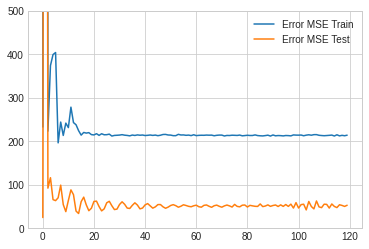

In [37]:
PlotMSE(train_hist_conf, test_hist_conf)

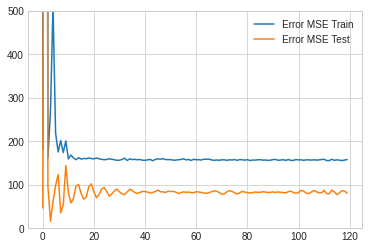

In [38]:
PlotMSE(train_hist_dead, test_hist_dead)

# **Predicción de Casos confirmados y fallecidos**

In [39]:
def Predecir(modelo, Xtest, dias_futuros = 15):
    with torch.no_grad():
        test_seq = Xtest[:1]
        preds = []
        for _ in range(dias_futuros):
            y_test_pred = modelo(test_seq)
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    return preds

In [40]:
def PreparacionDatosGrafica(preds, test, Data, scaler, futuro = 15):
    true_cases = DesNormalizar(test.flatten().numpy(), scaler)
    predicted_cases = DesNormalizar(preds, scaler)
    future_index = pd.date_range(start=Data.index[-7], periods= futuro+1, closed='left')
    future_cases = pd.Series(data=predicted_cases[-(futuro+1):], index=future_index)
    return true_cases, predicted_cases, future_cases

In [41]:
futuro = 15
preds_conf = Predecir(model_conf, X_test_conf, dias_futuros= len(X_test_conf) + futuro)
preds_dead = Predecir(model_dead, X_test_dead, dias_futuros= len(X_test_dead) + futuro)

In [42]:
true_cases_conf, predicted_cases_conf, future_cases_conf = PreparacionDatosGrafica(preds_conf, y_test_conf, confData, confScaler)
true_cases_dead, predicted_cases_dead, future_cases_dead = PreparacionDatosGrafica(preds_dead, y_test_dead, deadData, deadScaler)

In [43]:
def PloteoPrediccion(data, train, predicted, true, scaler, future_cases):
  diarios = pd.Series(data = scaler.inverse_transform(train).flatten(), index = data.index[:len(train)])
  reales = pd.Series(data = true, index = data.index[len(train):len(train) + len(true)] )
  predecidos = pd.Series(data = predicted[:-(futuro)], index = data.index[len(train):len(train) + len(true)] )
  #plt.plot(data.index[:len(train)], scaler.inverse_transform(train).flatten(), label='Historico de Casos diarios' )
  plt.plot(diarios, label='Historico de Casos diarios' )
  #plt.plot(data.index[len(train):len(train) + len(true)], true, label='Casos diarios reales')
  plt.plot(reales, label='Casos diarios reales')
  #plt.plot(data.index[len(train):len(train) + len(true)], predicted[:-futuro], label='Casos diarios predecidos' )
  plt.plot(predecidos, label='Casos diarios predecidos')
  plt.plot(future_cases, label='Casos diarios predecidos futuros' )

  plt.xticks(fontsize = 10, rotation=90)
  plt.tight_layout()
  plt.legend()

In [44]:
#PloteoPrediccion(deadregion, train_dead, predicted_cases_dead, true_cases_dead, future_cases_dead)

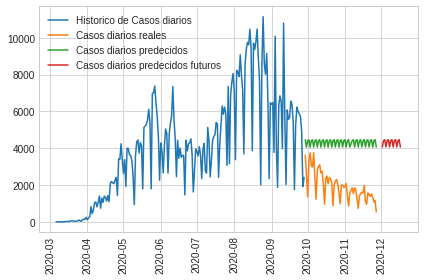

In [45]:
PloteoPrediccion(confData, train_conf, predicted_cases_conf, true_cases_conf, confScaler, future_cases_conf)

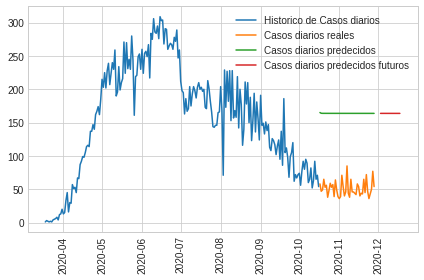

In [46]:
PloteoPrediccion(deadData, train_dead, predicted_cases_dead, true_cases_dead, deadScaler, future_cases_dead)

In [47]:
future_cases_dead

2020-12-03    163.866824
2020-12-04    163.865736
2020-12-05    163.864658
2020-12-06    163.863600
2020-12-07    163.862534
2020-12-08    163.861483
2020-12-09    163.860435
2020-12-10    163.859399
2020-12-11    163.858374
2020-12-12    163.857348
2020-12-13    163.856335
2020-12-14    163.855327
2020-12-15    163.854326
2020-12-16    163.853331
2020-12-17    163.852345
2020-12-18    163.851362
Freq: D, dtype: float64

In [48]:
def PrediccionRegiones(region: "", futuro = 15):
    confregion = DataRegion(region, 'positivo')
    deadregion = DataRegion(region, 'fallecido')
    #Creando variables para Modelo
    confScaler_region = Normalizar(confregion, 'CasosConfirmados')
    deadScaler_region = Normalizar(deadregion, 'Fallecidos')

    confNormal_region = confScaler_region.transform(confregion)
    deadNormal_region = deadScaler_region.transform(deadregion)
    #Crear subconjuntos train y test
    train_conf, test_conf = train_test_split(confNormal_region, test_size=.25, shuffle=False)
    train_dead, test_dead = train_test_split(deadNormal_region, test_size=.25, shuffle=False)
    
    X_train_conf, y_train_conf = CrearSecuencias(train_conf, seq_length)
    X_test_conf, y_test_conf = CrearSecuencias(test_conf, seq_length)
    #Secuencias para Fallecidos
    X_train_dead, y_train_dead = CrearSecuencias(train_dead, seq_length)
    X_test_dead, y_test_dead = CrearSecuencias(test_dead, seq_length)
    preds_conf = Predecir(model_conf, X_test_conf, dias_futuros= len(X_test_conf) + futuro)
    preds_dead = Predecir(model_dead, X_test_dead, dias_futuros= len(X_test_dead) + futuro)
    #print(preds_conf)

    true_cases_conf, predicted_cases_conf, future_cases_conf = PreparacionDatosGrafica(preds_conf, y_test_conf, confregion, confScaler_region, futuro)
    true_cases_dead, predicted_cases_dead, future_cases_dead = PreparacionDatosGrafica(preds_dead, y_test_dead, deadregion, deadScaler_region, futuro)
    PloteoPrediccion(confregion, train_conf, predicted_cases_conf, true_cases_conf, confScaler_region, future_cases_conf)
    plt.figure()
    PloteoPrediccion(deadregion, train_dead, predicted_cases_dead, true_cases_dead, deadScaler_region, future_cases_dead)
    #print(deadregion)
    return future_cases_conf, future_cases_dead

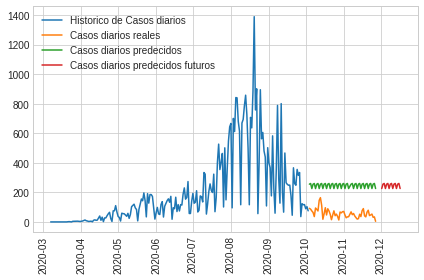

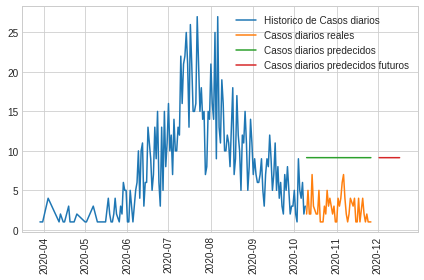

In [49]:
casos_aqp, dead_aqp = PrediccionRegiones("AREQUIPA")

In [50]:
casos_aqp

2020-12-02    226.830521
2020-12-03    256.427594
2020-12-04    261.182541
2020-12-05    226.848515
2020-12-06    256.445387
2020-12-07    261.200621
2020-12-08    226.866355
2020-12-09    256.463060
2020-12-10    261.218635
2020-12-11    226.884108
2020-12-12    256.480639
2020-12-13    261.236495
2020-12-14    226.901727
2020-12-15    256.498057
2020-12-16    261.254222
2020-12-17    226.919259
Freq: D, dtype: float64

In [51]:
dead_aqp

2020-12-02    9.137962
2020-12-03    9.137910
2020-12-04    9.137858
2020-12-05    9.137807
2020-12-06    9.137756
2020-12-07    9.137706
2020-12-08    9.137655
2020-12-09    9.137606
2020-12-10    9.137556
2020-12-11    9.137507
2020-12-12    9.137459
2020-12-13    9.137410
2020-12-14    9.137362
2020-12-15    9.137314
2020-12-16    9.137267
2020-12-17    9.137219
Freq: D, dtype: float64

In [52]:
def BusquedaParametros():
    num_layers = range(1,4)
    #num_features = range(500, 1001,500)
    sequence_size = range(5,16,5)
    test_size = np.arange(0.5,1.0,0.1)
    arr_mse = np.empty( (len(sequence_size), len(num_layers)))
    for test in test_size:
      #Creando test train data
      print ("##############")
      print ("Test size: ", test)
      print ("##############")
      train_conf, test_conf = train_test_split(confNormalizado, test_size=test,shuffle=False)
      for sequence in range(0, len(sequence_size)):
        #Creando Secuencias
        X_train, y_train = CrearSecuencias(train_conf, sequence)
        X_test, y_test = CrearSecuencias(test_conf, sequence)
        for layers in range(0, len(num_layers)):
          model = CoronaVirusPredictor(n_features=1, n_hidden=512, seq_len=sequence_size[sequence], n_layers=num_layers[layers])
          model, train_hist, test_hist = Train_model(model, X_train, y_train, X_test, y_test, num_epochs= 120, tasa=0.01)

          arr_mse[sequence,layers] = test_hist[-1]
    print(pd.DataFrame(arr_mse, index = sequence_size, columns = num_layers))




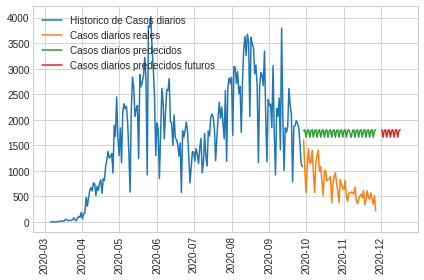

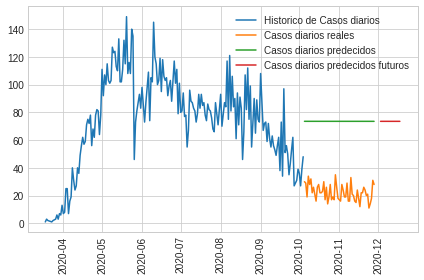

In [53]:
casos_lima, dead_lima = PrediccionRegiones("LIMA")

In [54]:
casos_lima

2020-12-02    1807.426580
2020-12-03    1658.872260
2020-12-04    1786.890976
2020-12-05    1807.493774
2020-12-06    1658.938760
2020-12-07    1786.956579
2020-12-08    1807.560795
2020-12-09    1659.004913
2020-12-10    1787.021922
2020-12-11    1807.627295
2020-12-12    1659.070776
2020-12-13    1787.086859
2020-12-14    1807.693246
2020-12-15    1659.136235
2020-12-16    1787.151392
2020-12-17    1807.759051
Freq: D, dtype: float64

In [55]:
dead_lima

2020-12-03    73.525311
2020-12-04    73.525120
2020-12-05    73.524934
2020-12-06    73.524744
2020-12-07    73.524558
2020-12-08    73.524373
2020-12-09    73.524188
2020-12-10    73.524007
2020-12-11    73.523824
2020-12-12    73.523643
2020-12-13    73.523464
2020-12-14    73.523286
2020-12-15    73.523109
2020-12-16    73.522931
2020-12-17    73.522759
2020-12-18    73.522586
Freq: D, dtype: float64